In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import expon, randint, uniform
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy import interp
from itertools import cycle

In [ ]:
data = pd.read_csv('/content/new-data.csv')

In [ ]:
# Define scores for various attributes
occupation_scores = {
    'teacher': 4,
    'health': 3,
    'services': 2,
    'at_home': 1,
    'other': 1
}

address_scores = {
    'U': 2,
    'R': 1
}

famsize_scores = {
    'GT3': 1,
    'LE3': 2
}

pstatus_scores = {
    'T': 2,
    'A': 1
}


traveltime_scores = {
    1: 4,
    2: 3,
    3: 2,
    4: 1
}


Sesorder_scores = {
    'High SES': 4,
    'Upper-Middle SES': 3,
    'Lower-Middle SES': 2,
    'Low SES': 1
}


In [ ]:
data['Mjob'] = data['Mjob'].map(occupation_scores)
data['Fjob'] = data['Fjob'].map(occupation_scores)
data['traveltime'] = data['traveltime'].map(traveltime_scores)
data['Pstatus'] = data['Pstatus'].map(pstatus_scores)
data['address'] = data['address'].map(address_scores)
data['SES_Group'] = data['SES_Group'].map(Sesorder_scores)
data['famsize'] = data['famsize'].map(famsize_scores)

In [ ]:
binary_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for column in binary_columns:
    data[column] = data[column].replace({'yes': 2, 'no': 1})

In [ ]:
data.select_dtypes(include=['object']).columns

In [ ]:
data.select_dtypes(include=['int64']).columns

Index(['age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'SES_Score', 'SES_Group'],
      dtype='object')

In [ ]:
data = data.drop(['G1', 'G2', 'G3'], axis=1)

In [ ]:
nominal_features = ['school', 'sex', 'reason', 'guardian']
num_features = ['age', 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'SES_Score', 'SES_Group']

In [ ]:
# Create polynomial features
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_features_array = poly_transformer.fit_transform(data[num_features])

#create feature names
poly_feature_names = poly_transformer.get_feature_names_out(num_features)
poly_features_df = pd.DataFrame(poly_features_array, columns=poly_feature_names)
data_enhanced = pd.concat([data, poly_features_df], axis=1)


In [ ]:
data_enhanced.head()

In [ ]:
data_enhanced['Grade_Category']

In [ ]:
X = data_enhanced.drop('Grade_Category', axis=1)
y = data_enhanced['Grade_Category']

X_nominal = X[nominal_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(drop='first'), nominal_features)
    ],
    remainder='passthrough'
)
X_nominal_encoded = preprocessor.fit_transform(X_nominal)
encoded_feature_names = preprocessor.get_feature_names_out()

if X_nominal_encoded.shape[1] != len(encoded_feature_names):
    raise ValueError("The shape of the encoded features does not match the number of feature names.")

X_nominal_encoded_df = pd.DataFrame(X_nominal_encoded.toarray(), columns=encoded_feature_names, index=X.index)

# Drop the original nominal features and concatenate the encoded ones
X_final = pd.concat([X.drop(nominal_features, axis=1), X_nominal_encoded_df], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


rf_classifier.fit(X_train, y_train)
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for the feature importances
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
top_features = importances_df.nlargest(30, 'Importance')['Feature']

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


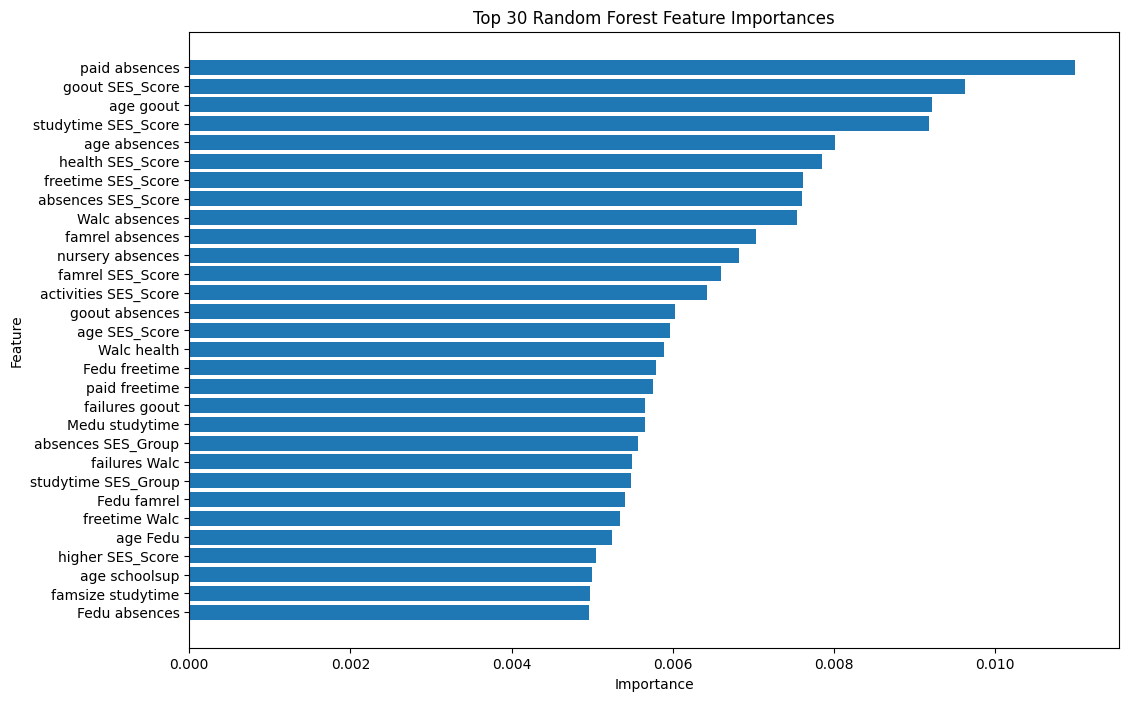

In [ ]:
top_importances_df = importances_df[importances_df['Feature'].isin(top_features)]
top_importances_sorted = top_importances_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(top_importances_sorted['Feature'], top_importances_sorted['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()


## RF Model

## Functions to evaluate model performance

In [ ]:
def evaluate_model(model, model_name, X_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)
    print(f'{model_name} Prediction Probabilities (First 5 Predictions):')
    print(y_pred_prob[:5])
    print('-' * 50)



In [ ]:

def evaluate_search(search_obj, search_type, X_test, y_test):
    print(f"Best parameters found by {search_type}: ", search_obj.best_params_)
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print(f'Classification Report of the best model ({search_type}):')
    print(classification_report(y_test, y_pred))
    y_pred_prob = best_model.predict_proba(X_test)
    print(f'Prediction Probabilities (First 5 Predictions) of the best model ({search_type}):')
    print(y_pred_prob[:5])
    print('-' * 50)


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_top, y_train)


In [ ]:
evaluate_model(rf_classifier, 'Random Forest', X_train_top, X_test_top, y_test)
#Random Forest Accuracy: 0.4177215189873418

Random Forest Accuracy: 0.4177215189873418
Random Forest Classification Report:
              precision    recall  f1-score   support

     At_risk       0.39      0.66      0.49        32
        Fail       0.42      0.30      0.35        27
        Pass       0.67      0.20      0.31        20

    accuracy                           0.42        79
   macro avg       0.49      0.38      0.38        79
weighted avg       0.47      0.42      0.39        79

Random Forest Prediction Probabilities (First 5 Predictions):
[[0.39 0.56 0.05]
 [0.45 0.52 0.03]
 [0.54 0.38 0.08]
 [0.67 0.22 0.11]
 [0.46 0.5  0.04]]
--------------------------------------------------


In [ ]:
rf_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42,
                           class_weight='balanced'))
])


In [ ]:
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_pipeline,
                           param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,)

grid_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search, 'GridSearchCV', X_test_top, y_test)
#Accuracy of the best model: 0.5063291139240507

Best parameters found by GridSearchCV:  {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Accuracy of the best model: 0.5063291139240507
Classification Report of the best model (GridSearchCV):
              precision    recall  f1-score   support

     At_risk       0.44      0.59      0.51        32
        Fail       0.61      0.41      0.49        27
        Pass       0.56      0.50      0.53        20

    accuracy                           0.51        79
   macro avg       0.54      0.50      0.51        79
weighted avg       0.53      0.51      0.51        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV):
[[0.285 0.685 0.03 ]
 [0.375 0.54  0.085]
 [0.37  0.455 0.175]
 [0.66  0.165 0.175]
 [0.31  0.595 0.095]]
--------------------------------------------------


In [ ]:
# Refined parameter grid
refined_param_grid = {
    'rf__n_estimators': [90, 100, 110],
    'rf__max_depth': [None, 30, 50, 70],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [3, 4, 5]
}

refined_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=refined_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)
refined_grid_search.fit(X_train_top, y_train)

In [ ]:
evaluate_search(refined_grid_search, 'GridSearch RF', X_test_top, y_test)
#Accuracy of the best model: 0.43037974683544306

Best parameters found by GridSearch RF:  {'rf__max_depth': None, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 90}
Accuracy of the best model: 0.43037974683544306
Classification Report of the best model (GridSearch RF):
              precision    recall  f1-score   support

     At_risk       0.35      0.38      0.36        32
        Fail       0.52      0.41      0.46        27
        Pass       0.46      0.55      0.50        20

    accuracy                           0.43        79
   macro avg       0.45      0.44      0.44        79
weighted avg       0.44      0.43      0.43        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch RF):
[[0.27469056 0.66623096 0.05907848]
 [0.43510277 0.49053604 0.07436119]
 [0.45485807 0.41076198 0.13437994]
 [0.64327925 0.19260647 0.16411428]
 [0.30558549 0.60237636 0.09203815]]
--------------------------------------------------


In [ ]:
param_dist = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 4),
    'rf__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(random_search, "RandomizedSearchCV", X_test_top, y_test)
#Accuracy of the best model: 0.4936708860759494

Best parameters found by RandomizedSearchCV:  {'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 4, 'rf__n_estimators': 108}
Accuracy of the best model: 0.4936708860759494
Classification Report of the best model (RandomizedSearchCV):
              precision    recall  f1-score   support

     At_risk       0.44      0.59      0.51        32
        Fail       0.59      0.37      0.45        27
        Pass       0.53      0.50      0.51        20

    accuracy                           0.49        79
   macro avg       0.52      0.49      0.49        79
weighted avg       0.51      0.49      0.49        79

Prediction Probabilities (First 5 Predictions) of the best model (RandomizedSearchCV):
[[0.35493827 0.63333333 0.0117284 ]
 [0.38333333 0.51265432 0.10401235]
 [0.53611111 0.32885802 0.13503086]
 [0.67685185 0.17808642 0.14506173]
 [0.40972222 0.52469136 0.06558642]]
--------------------------------------------------


## Logistic regression model

In [ ]:
logreg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
logreg.fit(X_train_top, y_train)


In [ ]:
evaluate_model(logreg, 'Logistic Regression', X_train_top, X_test_top, y_test)
#Logistic Regression Accuracy: 0.4810126582278481

Logistic Regression Accuracy: 0.4810126582278481
Logistic Regression Classification Report:
              precision    recall  f1-score   support

     At_risk       0.43      0.47      0.45        32
        Fail       0.63      0.44      0.52        27
        Pass       0.44      0.55      0.49        20

    accuracy                           0.48        79
   macro avg       0.50      0.49      0.49        79
weighted avg       0.50      0.48      0.48        79

Logistic Regression Prediction Probabilities (First 5 Predictions):
[[1.78760304e-01 8.18554454e-01 2.68524134e-03]
 [2.93561548e-01 6.85550892e-01 2.08875597e-02]
 [4.52780163e-01 4.84322407e-01 6.28974294e-02]
 [3.26742320e-01 2.87932968e-01 3.85324712e-01]
 [4.48262662e-01 5.51587423e-01 1.49914673e-04]]
--------------------------------------------------


In [ ]:
scaler = StandardScaler()
logreg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
logreg_pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', logreg)
])


In [ ]:

param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_logreg.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_logreg, "gridsearchcv", X_test_top, y_test)
#Accuracy of the best model: 0.4810126582278481

Best parameters found by gridsearchcv:  {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Accuracy of the best model: 0.4810126582278481
Classification Report of the best model (gridsearchcv):
              precision    recall  f1-score   support

     At_risk       0.44      0.44      0.44        32
        Fail       0.65      0.48      0.55        27
        Pass       0.41      0.55      0.47        20

    accuracy                           0.48        79
   macro avg       0.50      0.49      0.49        79
weighted avg       0.50      0.48      0.48        79

Prediction Probabilities (First 5 Predictions) of the best model (gridsearchcv):
[[1.73765475e-01 8.23397071e-01 2.83745394e-03]
 [3.06103339e-01 6.64171341e-01 2.97253201e-02]
 [4.50611357e-01 4.98164150e-01 5.12244922e-02]
 [3.08863062e-01 2.95114803e-01 3.96022136e-01]
 [4.20883141e-01 5.79049033e-01 6.78263369e-05]]
--------------------------------------------------


In [ ]:
logreg_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg',LogisticRegression(max_iter=5000,
     random_state=42, class_weight='balanced')),
])

param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
}

grid_search_logreg2 = GridSearchCV(
    logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_logreg2.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_logreg2, 'GridSearchCV', X_test_top, y_test)
#Accuracy of the best model: 0.5443037974683544

Best parameters found by GridSearchCV:  {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Accuracy of the best model: 0.5443037974683544
Classification Report of the best model (GridSearchCV):
              precision    recall  f1-score   support

     At_risk       0.57      0.41      0.47        32
        Fail       0.64      0.52      0.57        27
        Pass       0.47      0.80      0.59        20

    accuracy                           0.54        79
   macro avg       0.56      0.57      0.55        79
weighted avg       0.57      0.54      0.54        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV):
[[0.30386697 0.68451505 0.01161798]
 [0.41661645 0.50234057 0.08104298]
 [0.33279307 0.50298456 0.16422237]
 [0.29154852 0.25567751 0.45277397]
 [0.24515588 0.74344653 0.01139759]]
--------------------------------------------------


## SVM

In [ ]:
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_top, y_train)


In [ ]:
evaluate_model(svm_classifier, 'SVM', X_train_top, X_test_top, y_test)
#SVM Accuracy: 0.4050632911392405


In [ ]:
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42, class_weight='balanced'))
])

param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid=param_grid_svm,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_svm.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_svm, "GrideSearchCV", X_test_top, y_test)
#Accuracy of the best model: 0.46835443037974683


Best parameters found by GrideSearchCV:  {'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}
Accuracy of the best model: 0.46835443037974683
Classification Report of the best model (GrideSearchCV):
              precision    recall  f1-score   support

     At_risk       0.43      0.91      0.58        32
        Fail       0.80      0.15      0.25        27
        Pass       0.67      0.20      0.31        20

    accuracy                           0.47        79
   macro avg       0.63      0.42      0.38        79
weighted avg       0.61      0.47      0.40        79

Prediction Probabilities (First 5 Predictions) of the best model (GrideSearchCV):
[[0.39896351 0.44027278 0.16076371]
 [0.38178883 0.35364845 0.26456272]
 [0.369852   0.32791229 0.30223571]
 [0.36772554 0.32731094 0.30496352]
 [0.39311309 0.47412262 0.13276429]]
--------------------------------------------------


In [ ]:
param_grid_svm_refined = {
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__kernel': ['rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svm__degree': [2, 3, 4]
}

grid_search_svm_refined = GridSearchCV(
    svm_pipeline,
    param_grid=param_grid_svm_refined,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit the grid search to the data
grid_search_svm_refined.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search_svm_refined, "GridSearch", X_test_top, y_test)

Best parameters found by GridSearch:  {'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 0.01, 'svm__kernel': 'poly'}
Accuracy of the best model: 0.45569620253164556
Classification Report of the best model (GridSearch):
              precision    recall  f1-score   support

     At_risk       0.42      0.88      0.57        32
        Fail       0.60      0.11      0.19        27
        Pass       0.71      0.25      0.37        20

    accuracy                           0.46        79
   macro avg       0.58      0.41      0.37        79
weighted avg       0.56      0.46      0.39        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch):
[[0.41593712 0.47449065 0.10957222]
 [0.39513396 0.36420087 0.24066517]
 [0.37575731 0.33257093 0.29167175]
 [0.37343564 0.3223826  0.30418176]
 [0.41991872 0.5171997  0.06288158]]
--------------------------------------------------


## GBM

In [ ]:
# XGBoost requires numeric labels for classification esp when using multi:softmax objective.
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

xgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(objective='multi:softmax', random_state=42))
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit the GridSearchCV with encoded labels
grid_search_xgb.fit(X_train_top, y_train_encoded)


In [ ]:
y_test_encoded = le.fit_transform(y_test)
evaluate_search(grid_search_xgb, "XGB", X_test_top, y_test_encoded)
#Accuracy of the best model: 0.3924050632911392

Best parameters found by XGB:  {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Accuracy of the best model: 0.3924050632911392
Classification Report of the best model (XGB):
              precision    recall  f1-score   support

           0       0.34      0.44      0.38        32
           1       0.48      0.41      0.44        27
           2       0.40      0.30      0.34        20

    accuracy                           0.39        79
   macro avg       0.41      0.38      0.39        79
weighted avg       0.40      0.39      0.39        79

Prediction Probabilities (First 5 Predictions) of the best model (XGB):
[[0.23691466 0.75220084 0.01088453]
 [0.04934758 0.9482511  0.00240133]
 [0.6057532  0.32146057 0.07278621]
 [0.963622   0.02467736 0.01170055]
 [0.090885   0.8973131  0.01180188]]
--------------------------------------------------


In [ ]:
param_grid_xgb_expanded = {
    'xgb__n_estimators': [300, 500, 700],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [7, 9, 11],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__gamma': [0, 0.1, 0.2]
}

grid_search_xgb_expanded = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb_expanded,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_xgb_expanded.fit(X_train_top, y_train_encoded)


In [ ]:
evaluate_search(grid_search_xgb_expanded, "GridSearchCV", X_test_top, y_test_encoded)
#Accuracy of the best model: 0.4050632911392405

Best parameters found by GridSearchCV:  {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}
Accuracy of the best model: 0.4050632911392405
Classification Report of the best model (GridSearchCV):
              precision    recall  f1-score   support

           0       0.34      0.41      0.37        32
           1       0.48      0.41      0.44        27
           2       0.44      0.40      0.42        20

    accuracy                           0.41        79
   macro avg       0.42      0.40      0.41        79
weighted avg       0.41      0.41      0.41        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV):
[[0.19886163 0.78961295 0.01152536]
 [0.08340146 0.9097024  0.00689614]
 [0.48520684 0.42401636 0.09077688]
 [0.8673538  0.02829414 0.10435197]
 [0.2066342  0.78061426 0.0127515 ]]
--------------------------------------------------


## Model stacking

In [ ]:
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada_boost_rf', AdaBoostClassifier(
        base_estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
        random_state=42))
])

param_grid_ada_rf = {
    'ada_boost_rf__base_estimator__n_estimators': [50, 100, 150],
    'ada_boost_rf__base_estimator__max_depth': [5, 10, 15, None],
    'ada_boost_rf__n_estimators': [30, 50, 70],
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1]
}

grid_search_ada_rf = GridSearchCV(
    ada_pipeline,
    param_grid=param_grid_ada_rf,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_ada_rf.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search_ada_rf, "GridSearchCV ada", X_test_top, y_test)

Best parameters found by GridSearchCV ada:  {'ada_boost_rf__base_estimator__max_depth': 5, 'ada_boost_rf__base_estimator__n_estimators': 100, 'ada_boost_rf__learning_rate': 0.1, 'ada_boost_rf__n_estimators': 30}
Accuracy of the best model: 0.45569620253164556
Classification Report of the best model (GridSearchCV ada):
              precision    recall  f1-score   support

     At_risk       0.40      0.50      0.44        32
        Fail       0.58      0.41      0.48        27
        Pass       0.45      0.45      0.45        20

    accuracy                           0.46        79
   macro avg       0.48      0.45      0.46        79
weighted avg       0.47      0.46      0.46        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV ada):
[[0.36869639 0.51034777 0.12095584]
 [0.40356251 0.42177653 0.17466097]
 [0.39879459 0.38749025 0.21371515]
 [0.47357988 0.27166153 0.25475859]
 [0.37124133 0.49407319 0.13468548]]
---------------------------------

## function to return full array of predictions

In [ ]:
def get_model_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob


In [ ]:
def get_search_pred(search_obj, X_test, y_test):
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print("Classification Report of the best model:",{best_model})
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob


In [ ]:
# collecting the data
y_test_gs1, y_pred_gs1, y_pred_prob_gs1 = get_search_pred(grid_search, X_test_top, y_test)
y_test_gs2, y_pred_gs2, y_pred_prob_gs2 = get_search_pred(grid_search_logreg2, X_test_top, y_test)
y_test_gs3, y_pred_gs3, y_pred_prob_gs3 = get_search_pred(grid_search_svm, X_test_top, y_test)
#y_test_gs4, y_pred_gs4, y_pred_prob_gs4 = get_search_pred(grid_search_xgb_expanded, X_test_top, y_test)
y_test_gs5, y_pred_gs5, y_pred_prob_gs5 = get_search_pred(grid_search_ada_rf, X_test_top, y_test)


Accuracy of the best model: 0.5063291139240507
Classification Report of the best model: {Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])}
              precision    recall  f1-score   support

     At_risk       0.44      0.59      0.51        32
        Fail       0.61      0.41      0.49        27
        Pass       0.56      0.50      0.53        20

    accuracy                           0.51        79
   macro avg       0.54      0.50      0.51        79
weighted avg       0.53      0.51      0.51        79

Accuracy of the best model: 0.5443037974683544
Classification Report of the best model: {Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                 

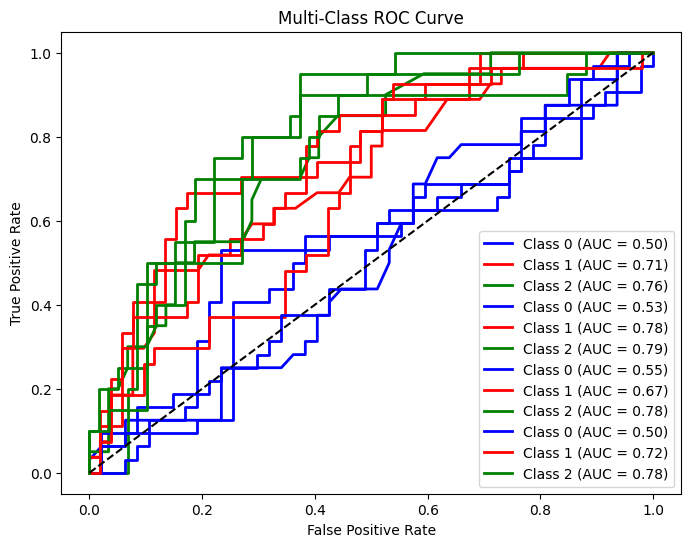

In [ ]:
# Function to plot ROC curve for each class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

def plot_multiclass_roc(y_true, y_pred_prob, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.figure(figsize=(8, 6))
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs1, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs2, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs3, n_classes)
#plot_multiclass_roc(y_test_binarized, y_pred_prob_gs4, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs5, n_classes)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

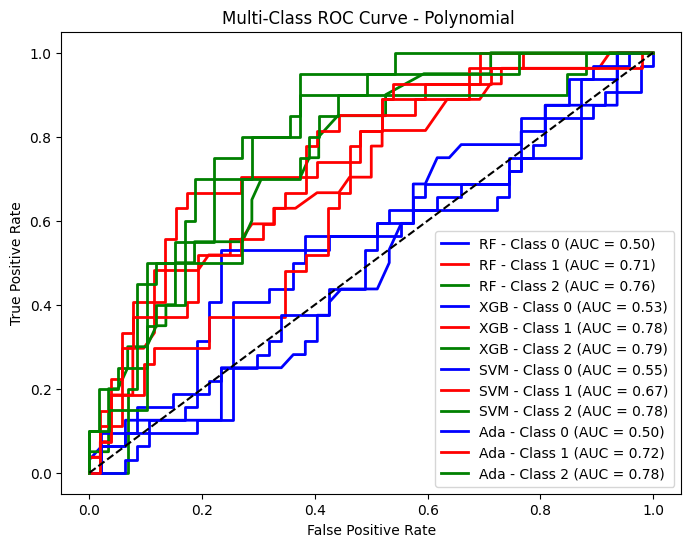

In [ ]:
def plot_multiclass_roc(y_true, y_pred_prob, n_classes, model_label):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_label} - Class {i} (AUC = {roc_auc[i]:.2f})')

# Binarize the y_test for multiclass ROC plot
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))

# Plot ROC for each model
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs1, n_classes, 'RF')
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs2, n_classes, "XGB")
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs3, n_classes, "SVM")
#plot_multiclass_roc(y_test_binarized, y_pred_prob_gs4, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs5, n_classes, "Ada")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve - Polynomial ')
plt.legend(loc="lower right")
plt.show()


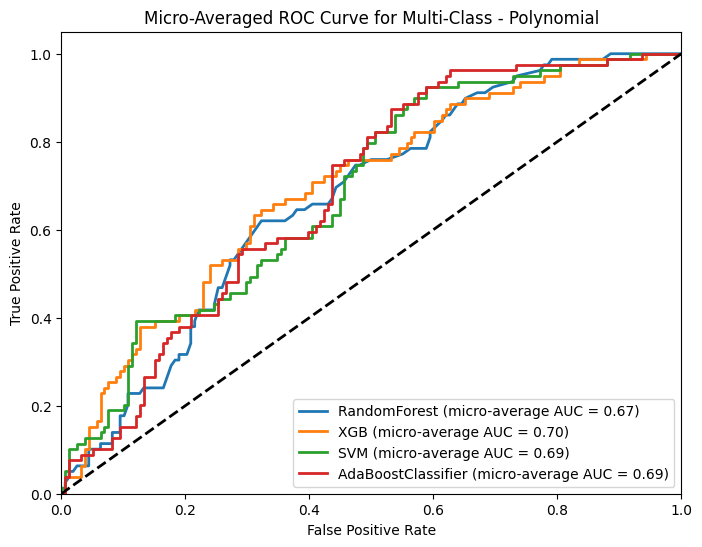

In [ ]:
# Function to plot ROC curve for each model with micro-averaging
def plot_micro_averaged_roc_curve(y_true, y_score, n_classes, ax, name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # micro-average ROC curve & ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"],
            label=f'{name} (micro-average AUC = {roc_auc["micro"]:0.2f})',
            linestyle='-', linewidth=2)


fig, ax = plt.subplots(figsize=(8, 6))
# score arrays from best models
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'RandomForest')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs2, n_classes, ax, 'XGB')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs3, n_classes, ax, 'SVM')
#plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs4, n_classes, ax, 'SVM')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs5, n_classes, ax, 'AdaBoostClassifier')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Micro-Averaged ROC Curve for Multi-Class - Polynomial')
ax.legend(loc="lower right")
plt.show()

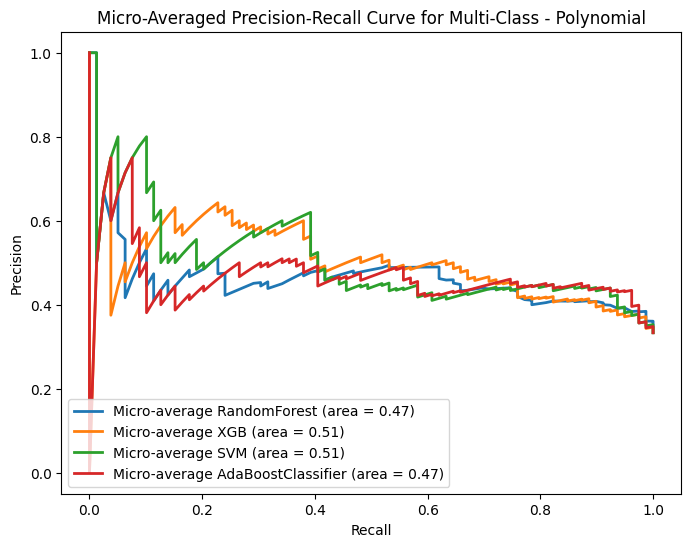

In [ ]:
# Function to plot Precision-Recall curve for each model with micro-averaging
def plot_micro_averaged_precision_recall_curve(y_true, y_score, n_classes, ax, name):
    precision = dict()
    recall = dict()
    average_precision = dict()

    # micro-average precision-recall & AUC
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_score, average="micro")

    ax.plot(recall["micro"], precision["micro"], lw=2,
             label=f'Micro-average {name} (area = {average_precision["micro"]:0.2f})')

fig, ax = plt.subplots(figsize=(8, 6))
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'RandomForest')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs2, n_classes, ax, 'XGB')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs3, n_classes, ax, 'SVM')
#plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs4, n_classes, ax, 'SVM Model')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs5, n_classes, ax, 'AdaBoostClassifier')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Micro-Averaged Precision-Recall Curve for Multi-Class - Polynomial')
ax.legend(loc="lower left")
plt.show()

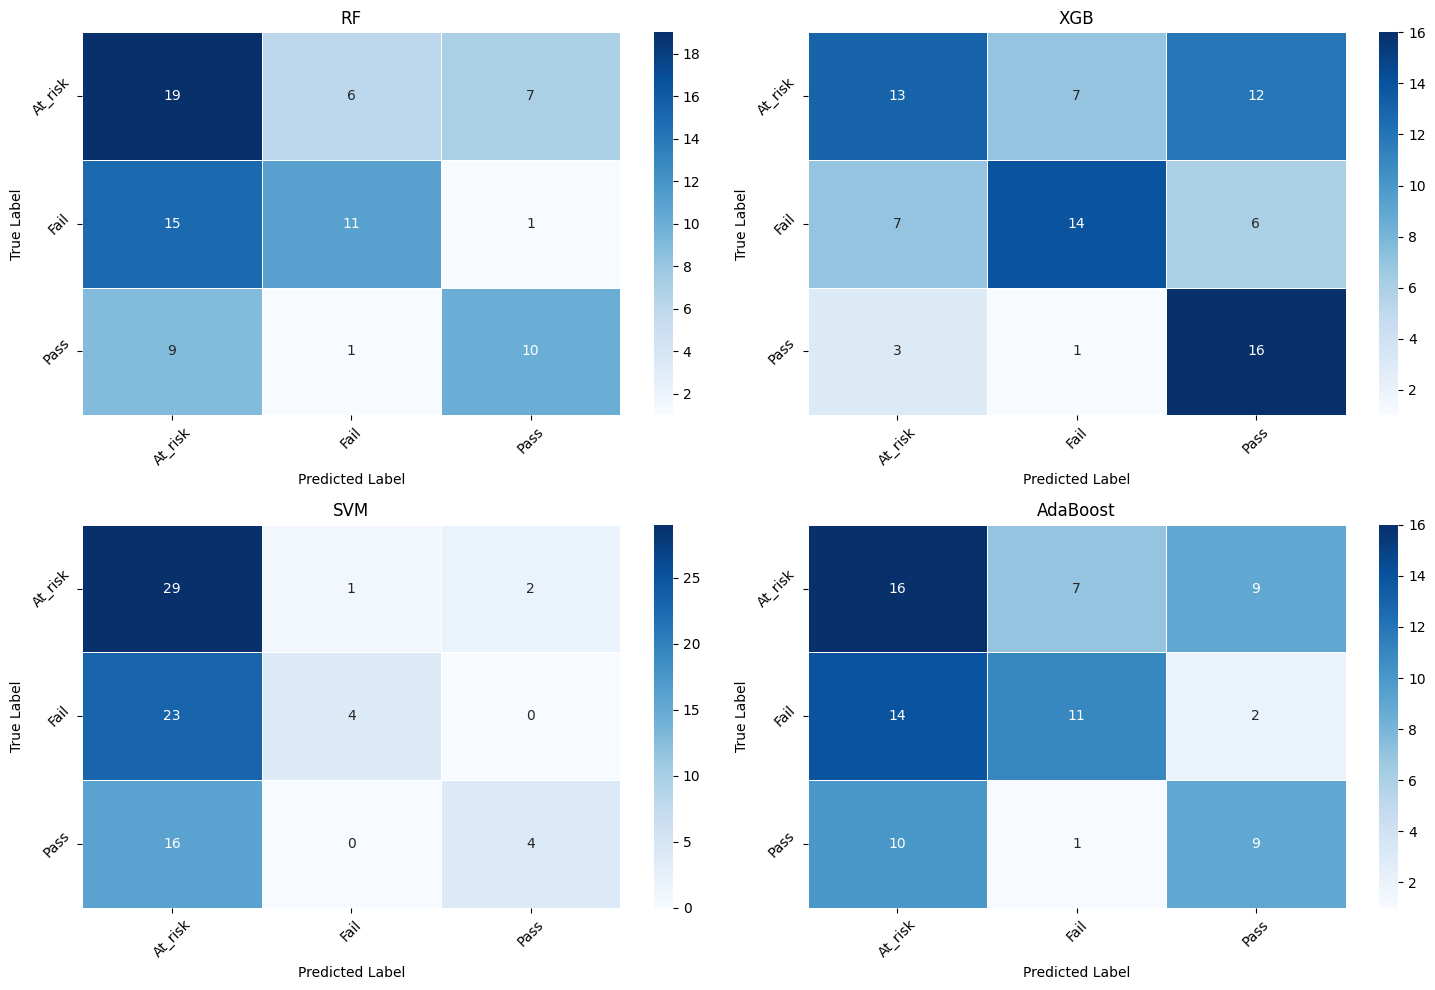

In [ ]:
# function to plot the confusion matrix of best models
def plot_confusion_matrix(cm, classes, title, ax, cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, ax=ax, cmap=cmap)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
class_labels = np.unique(y_test)
predictions = [
    (y_test_gs1, y_pred_gs1, 'RF'),
    (y_test_gs2, y_pred_gs2, 'XGB'),
    (y_test_gs3, y_pred_gs3, 'SVM'),
    (y_test_gs5, y_pred_gs5, 'AdaBoost'),
]

for i, (y_test, y_pred, title) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes.flat[i]
    plot_confusion_matrix(cm, class_labels, title, ax)
#fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()